In [1]:
import re
import os
import nltk
import mglearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tika import parser
from bs4 import BeautifulSoup     
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, LeaveOneOut, ShuffleSplit
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
%matplotlib notebook

## Data Processing

In [2]:
'''
Fetching labels from db dump
b -> biological
p -> physical
w -> water quality
'''
training_group = []
labels = pd.read_csv('data/drd_cit_stud.csv')
df = labels.loc[:,['resultscitationid', 'resultsindex_biological', 
                'resultsindex_physical', 'resultsindex_waterquality']]  # subset df to include citationid and labels
for i in df.iterrows():
    l = ['b', 'p', 'w']
    d = [i[1][1], i[1][2], i[1][3]]
    max_value = max(d)
    max_index = d.index(max_value)
    training_group.append((i[1][0],l[max_index]))

In [3]:
# label totals
list_training_titles, list_training_labels = zip(*training_group)
print('Biological: %d\nPhysical: %d\nWater Quality: %d' %(list_training_labels.count('b'), list_training_labels.count('p'), list_training_labels.count('w')))

Biological: 63
Physical: 87
Water Quality: 11


Processing the corpus documents

In [4]:
raw_corpus_list = os.listdir('../data/pdf/')

In [5]:
'''
Removing non-letters, lowercase and removing stopwords
'''
def clean_doc_data(raw_review):
    letters_only = re.sub("[^a-zA-Z]", " ", raw_review) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops]   
    return(" ".join(meaningful_words))

In [6]:
'''
Pre-processing
Using tika to parse pdfs and placing into doc_text list by document
'''
doc_labels = []
doc_text = []
train_label = []
for file in raw_corpus_list:
    for i in training_group:
        if str(i[0] + '.pdf') == file:
            if file.endswith('.pdf'):
                try:
                    text = parser.from_file('../data/pdf/' + file)
                    tmp = clean_doc_data(text['content'])
                    doc_text.append(tmp)
                    doc_labels.append(file)
                    train_label.append(i[1])
                    print('O -' + str(file))
                except Exception as e:
                    print('X - ' + str(e) + ' --- ' + str(file))

O -Ahearn_Dahlgren_2005_Limnology and Oceanography.pdf
O -Amos_2008_Thesis.pdf
O -Ashley et al._2006_Environmental Monitoring and Assessment.pdf
O -Berthelote_2013_Thesis.pdf
O -Bountry_etal_2013_Reviews in Engineering Geology.pdf
O -Bowman_2001_Thesis.pdf
O -Brazell_Cole_2009_Journal of the Pennsylvania Academy of Science.pdf
O -Bulak_etal_2011_Report.pdf
O -Burdick,_Hightower_2006_Transactions of the American Fisheries Society.pdf
O -Burroughs_2003_Thesis.pdf
O -Burroughs_2007_Thesis_Ch2.pdf
O -Burroughs_2007_Thesis_Ch3.pdf
O -Burroughs_etal_2009_Geomorphology.pdf
O -Cannatelli_Curran_2012_Journal of Hydraulic Engineering.pdf
O -Cantwell_etal_2014_Environmental monitoring and assessment.pdf
O -Casper_etal_2006_Archiv fuer Hydrobiologie Supplement.pdf
O -Catalano_2002_Thesis.pdf
O -Catalano_etal_2007_North American Journal of Fisheries Management.pdf
O -Chaplin_etal_2005_Report.pdf
O -Chen_2012_Thesis.pdf
O -Cheng_Granata_2007_Water Resources Research.pdf
O -Chiu_etal_2013_Aquatic Eco

## Subsetting the Data
Note -- go back and use random sampling and try to view dist

In [7]:
# 80/20 train/test split
x_train = doc_text[:120]
y_train = train_label[:120]
x_test = doc_text[120:]
y_test = train_label[120:]

len(x_train), len(x_test)
print('There are %d document labels total\nThere are %d training labels applied\nThere are %d documents' %(len(doc_labels), len(train_label), len(doc_text)))

There are 149 document labels total
There are 149 training labels applied
There are 149 documents


# Create Features

In [8]:
# Initialize the "CountVectorizer" 
vectorizer = CountVectorizer(analyzer = "word", 
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = None, 
                             max_features = 5000) 

train_data_features = vectorizer.fit_transform(x_train)
train_data_features = train_data_features.toarray()

# TEST only transform
test_data_features = vectorizer.transform(x_test)
test_data_features = test_data_features.toarray()

# Data for cross validation 
x_train_cross_validation = vectorizer.fit_transform(doc_text).toarray()

In [9]:
train_data_features.shape

(120, 5000)

## Vocabulary

In [10]:
vocab = vectorizer.get_feature_names()
print(vocab)

['aa', 'ab', 'abandoned', 'abbreviations', 'ability', 'abiotic', 'abkhghfb', 'able', 'abrasion', 'absence', 'absent', 'absolute', 'abstract', 'abun', 'abundance', 'abundances', 'abundant', 'ac', 'academic', 'academy', 'accepted', 'access', 'accessed', 'accessible', 'accompanied', 'accompanying', 'accomplished', 'according', 'account', 'accounted', 'accounting', 'accounts', 'accrual', 'accumulated', 'accumulation', 'accumulations', 'accuracy', 'accurate', 'accurately', 'ace', 'achieve', 'achieved', 'acid', 'acknowledgements', 'acknowledgments', 'acoustic', 'acquired', 'acre', 'across', 'act', 'acta', 'acted', 'acting', 'action', 'actions', 'active', 'actively', 'activities', 'activity', 'actual', 'actually', 'ad', 'adams', 'adapted', 'add', 'added', 'adding', 'addition', 'additional', 'additionally', 'address', 'addressed', 'adequate', 'adequately', 'adjacent', 'adjust', 'adjusted', 'adjusting', 'adjustment', 'adjustments', 'administration', 'adult', 'adults', 'advances', 'advantage', '

In [11]:
# Sum up the counts of each vocabulary word
dist = np.sum(train_data_features, axis=0)

# For each, print the vocabulary word and the number of times it 
# appears in the training set
for tag, count in zip(vocab, dist):
    print(count, tag)

37 aa
22 ab
244 abandoned
81 abbreviations
158 ability
103 abiotic
55 abkhghfb
142 able
45 abrasion
98 absence
89 absent
70 absolute
135 abstract
26 abun
708 abundance
121 abundances
195 abundant
54 ac
43 academic
28 academy
23 accepted
22 access
58 accessed
218 accessible
86 accompanied
70 accompanying
22 accomplished
26 according
32 account
128 accounted
110 accounting
71 accounts
29 accrual
36 accumulated
28 accumulation
131 accumulations
112 accuracy
22 accurate
108 accurately
59 ace
37 achieve
66 achieved
31 acid
62 acknowledgements
53 acknowledgments
66 acoustic
64 acquired
24 acre
33 across
33 act
395 acta
69 acted
57 acting
30 action
23 actions
55 active
99 actively
193 activities
36 activity
182 actual
154 actually
126 ad
48 adams
599 adapted
35 add
49 added
23 adding
87 addition
29 additional
337 additionally
375 address
146 addressed
78 adequate
33 adequately
31 adjacent
28 adjust
238 adjusted
67 adjusting
77 adjustment
28 adjustments
233 administration
264 adult
28 adults
2

# Random Forest

In [12]:
forest = RandomForestClassifier(n_estimators = 100) 
# bag of words as features and the sentiment labels as the response variable

forest = forest.fit(train_data_features, y_train)
forest_CV = RandomForestClassifier(n_estimators = 100) 
scores = cross_val_score(forest_CV, x_train_cross_validation, train_label, cv=10)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.82 (+/- 0.15)


In [14]:
result = forest.predict(test_data_features)  # train/test split ver

#### Model Evaluation

In [16]:
print('Evaluation of poor train test distribution set')
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, result)))
print('Confusion Matrix: \n{}'.format(confusion_matrix(y_test, result, labels=['p','b','w'])))

Evaluation of poor train test distribution set
Accuracy: 0.759
Confusion Matrix: 
[[18  1  0]
 [ 0  4  0]
 [ 5  1  0]]


<IPython.core.display.Javascript object>


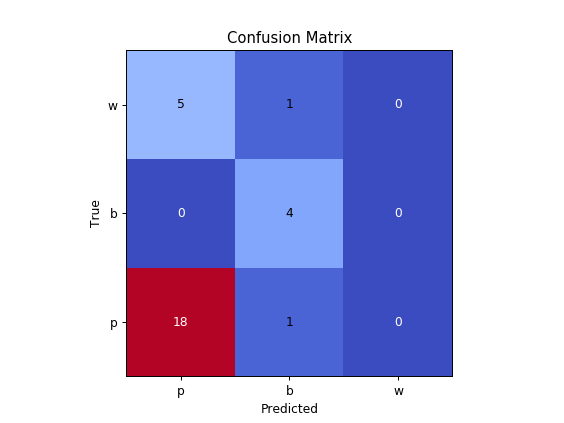

<bound method _AxesBase.invert_yaxis of <matplotlib.axes._subplots.AxesSubplot object at 0x11530c9b0>>

In [17]:
scores_img = mglearn.tools.heatmap(confusion_matrix(y_test, result, labels=['p','b','w']), xlabel='Predicted',
                                  ylabel='True', xticklabels=['p','b','w'], yticklabels=['p','b','w'], 
                                  cmap=plt.cm.coolwarm, fmt="%d")
plt.title('Confusion Matrix')
plt.gca().invert_yaxis

In [18]:
print(classification_report(y_test, result))

             precision    recall  f1-score   support

          b       0.67      1.00      0.80         4
          p       0.78      0.95      0.86        19
          w       0.00      0.00      0.00         6

avg / total       0.60      0.76      0.67        29



/Users/bserna/anaconda/envs/py3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [19]:
f1_score(y_test, result, average='micro'), f1_score(y_test, result, average='macro')

/Users/bserna/anaconda/envs/py3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.75862068965517238, 0.55238095238095231)

### Leave one out Cross Validation
Normally good for estimating smaller datasets, larger take increased time. 

In [20]:
loo = LeaveOneOut()
scores = cross_val_score(forest_CV, x_train_cross_validation, train_label, cv=loo)


print('Number of cv iterations: ', len(scores))
print('Mean Accuracy: {:.2f}'.format(scores.mean()))

Number of cv iterations:  149
Mean Accuracy: 0.83


### Shuffle Split Cross Validation

In [21]:
shuffle_split = ShuffleSplit(test_size=.5, train_size=.5, n_splits=10)
scores = cross_val_score(forest_CV, x_train_cross_validation, train_label, cv=shuffle_split)

print('Cross validation scores:\n{}'.format(scores))
print('Average: {:.2f}'.format(scores.mean()))

Cross validation scores:
[ 0.78666667  0.8         0.85333333  0.84        0.8         0.85333333
  0.78666667  0.88        0.68        0.88      ]
Average: 0.82


## Gradient Boosting Machine

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

In [23]:
gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.01)
scores = cross_val_score(gbrt, x_train_cross_validation, train_label, cv=shuffle_split)

In [24]:
print('Cross validation scores:\n{}'.format(scores))
print('Average: {:.2f}'.format(scores.mean()))

Cross validation scores:
[ 0.74666667  0.76        0.74666667  0.70666667  0.76        0.77333333
  0.78666667  0.78666667  0.76        0.73333333]
Average: 0.76


## Multinomial Naive Bayes

In [25]:
clf = MultinomialNB()
clf.fit(train_data_features, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [26]:
clf = MultinomialNB()
scores = cross_val_score(clf, x_train_cross_validation, train_label, cv=10)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.85 (+/- 0.14)


In [27]:
clf = MultinomialNB()
clf.fit(train_data_features, y_train)
nb_pred = clf.predict(test_data_features)

In [29]:
accuracy_score(y_test, nb_pred)

0.75862068965517238

In [30]:
confusion_matrix(y_test, nb_pred, labels=['p','b','w'])

array([[18,  1,  0],
       [ 0,  4,  0],
       [ 6,  0,  0]])